<a href="https://colab.research.google.com/github/poojan14/AIMS/blob/main/aims_lstm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
download = drive.CreateFile({'id':'1YjY8wddLDyUhhb5xeP1Zfl4KjGRRAoe0'})


In [ ]:
download.GetContentFile('aims.csv')
import pandas as pd
import numpy as np
df=pd.read_csv('aims.csv')


In [ ]:
df.head(10)

,date time,date,time,seconds since 1970,Humidity,Water Temperature,Air Temperature,Air Pressure
0,2020-08-06T00:00:00+1000,06-08-2020,00:00:00,1.600000e+09,73.0,22.57,22.2,1014.0
1,2020-08-06T00:10:00+1000,06-08-2020,00:10:00,1.600000e+09,71.8,22.57,22.3,1013.7
2,2020-08-06T00:20:00+1000,06-08-2020,00:20:00,1.600000e+09,71.9,22.58,22.3,1013.8
3,2020-08-06T00:30:00+1000,06-08-2020,00:30:00,1.600000e+09,71.1,22.57,22.2,1013.5
4,2020-08-06T00:40:00+1000,06-08-2020,00:40:00,1.600000e+09,73.9,22.56,22.2,1013.6
5,2020-08-06T00:50:00+1000,06-08-2020,00:50:00,1.600000e+09,73.8,22.56,22.3,1013.5
6,2020-08-06T01:00:00+1000,06-08-2020,01:00:00,1.600000e+09,74.9,22.56,22.3,1013.3
7,2020-08-06T01:10:00+1000,06-08-2020,01:10:00,1.600000e+09,73.2,22.56,22.3,1013.3
8,2020-08-06T01:20:00+1000,06-08-2020,01:20:00,1.600000e+09,71.6,22.56,22.3,1013.3
9,2020-08-06T01:30:00+1000,06-08-2020,01:30:00,1.600000e+09,74.2,22.56,22.3,1013.3


In [ ]:
df.shape

(22454, 8)

In [ ]:
df.isnull().sum()

date time             0
date                  0
time                  0
seconds since 1970    0
Humidity              0
Water Temperature     0
Air Temperature       0
Air Pressure          0
dtype: int64

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
TRAIN_SPLIT=20000
tf.random.set_seed(13)

In [ ]:
df.columns

Index(['date time', 'date', 'time', 'seconds since 1970', 'Humidity ',
       'Water Temperature ', 'Air Temperature ', 'Air Pressure '],
      dtype='object')

In [ ]:
features_considered=['Air Temperature ','Water Temperature ', 'Air Pressure ','Humidity ']
features=df[features_considered]
features.index=df['date time']
features.head()

,Air Temperature,Water Temperature,Air Pressure,Humidity
date time,,,,
2020-08-06T00:00:00+1000,22.2,22.57,1014.0,73.0
2020-08-06T00:10:00+1000,22.3,22.57,1013.7,71.8
2020-08-06T00:20:00+1000,22.3,22.58,1013.8,71.9
2020-08-06T00:30:00+1000,22.2,22.57,1013.5,71.1
2020-08-06T00:40:00+1000,22.2,22.56,1013.6,73.9


In [ ]:
dataset=features.values
data_mean=dataset.mean(axis=0)
data_std=dataset.std(axis=0)


In [ ]:
dataset=(dataset-data_mean)/data_std

In [ ]:
dataset

array([[-1.2651471 , -1.55793008,  0.30227999,  0.17159198],
       [-1.21459183, -1.55793008,  0.22803346,  0.04259927],
       [-1.21459183, -1.55271708,  0.2527823 ,  0.05334866],
       ...,
       [ 1.21206114,  1.45518109, -1.52913437,  1.37552392],
       [ 1.16150587,  1.45518109, -1.57863206,  1.50451663],
       [ 1.1109506 ,  1.45518109, -1.62812974,  1.33252635]])

In [ ]:
def multivariate_data(dataset,target,start_index,end_index,history_size,target_size,step,single_step=False):
  data=[]
  labels=[]
  start_index=start_index+history_size
  if end_index is None:
    end_index=len(dataset)-target_size

  for i in range(start_index,end_index):
    indices=range(i-history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  return np.array(data),np.array(labels)

In [ ]:
def create_time_steps(length):
  time_steps=[]
  for i in range(-length,0,1):
    time_steps.append(i)
  return time_steps  


In [ ]:
def show_plot(plot_data,delta,title):
  labels=['History','True Future','Model Prediction']
  marker=['.-','rx','go']
  time_steps=create_time_steps(plot_data[0].shape[0])
  if delta:
    future=delta
  else:
    future=0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


In [ ]:
BATCH_SIZE=256
BUFFER_SIZE=1000
EPOCHS=10
EVALUATION_INTERVAL=200
past_history=720
future_target = 72
STEP=6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


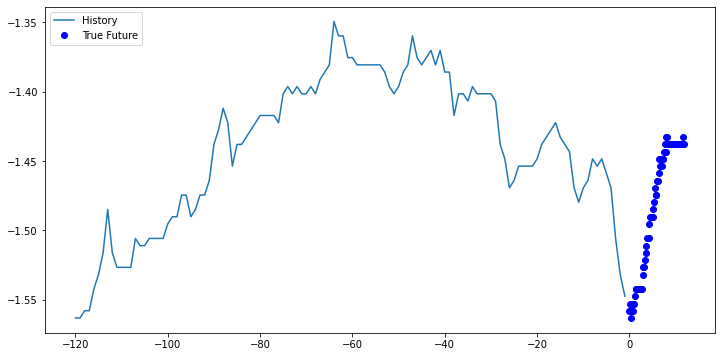

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))


In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


Epoch 1/10
200/200 [==============================] - 37s 171ms/step - loss: 6878.8827 - val_loss: 0.6323
Epoch 2/10
200/200 [==============================] - 34s 170ms/step - loss: 235.7999 - val_loss: 0.2425
Epoch 3/10
200/200 [==============================] - 34s 170ms/step - loss: 31.5017 - val_loss: 0.1593
Epoch 4/10
200/200 [==============================] - 34s 172ms/step - loss: 0.1149 - val_loss: 0.1777
Epoch 5/10
200/200 [==============================] - 35s 173ms/step - loss: 0.0865 - val_loss: 0.0953
Epoch 6/10
200/200 [==============================] - 35s 174ms/step - loss: 0.0783 - val_loss: 0.3458
Epoch 7/10
200/200 [==============================] - 34s 172ms/step - loss: 0.0833 - val_loss: 0.1756
Epoch 8/10
200/200 [==============================] - 35s 173ms/step - loss: 0.0660 - val_loss: 0.1806
Epoch 9/10
200/200 [==============================] - 35s 173ms/step - loss: 0.0700 - val_loss: 0.3263
Epoch 10/10
200/200 [==============================] - 35s 173ms/st

In [ ]:
def plot_train_history(history,title):
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs=range(len(loss))
  plt.figure()
  plt.plot(epochs,loss,'b',label='Training loss')
  plt.plot(epochs,val_loss,'r',label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

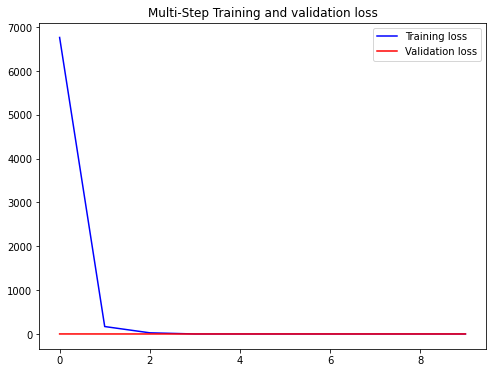

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


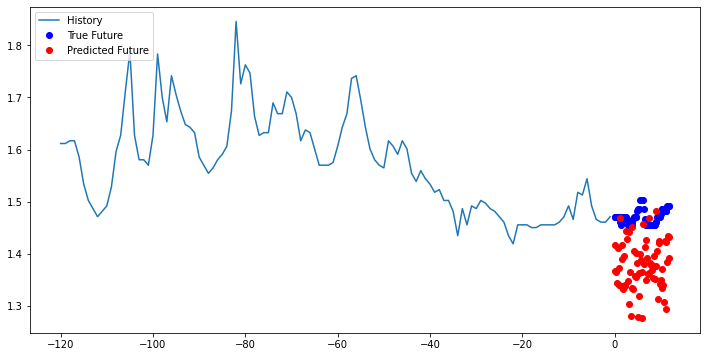

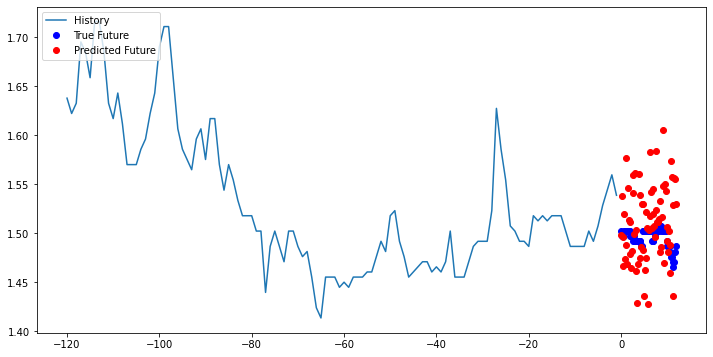

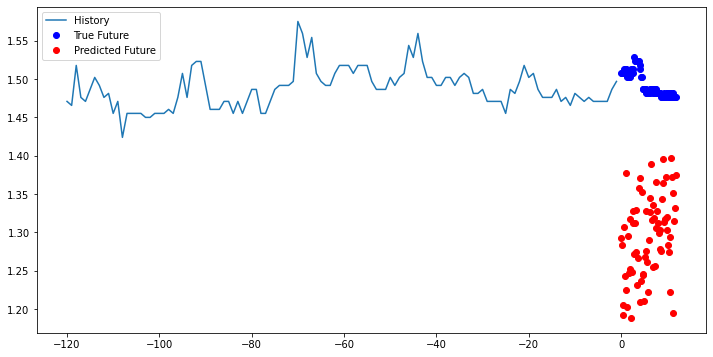

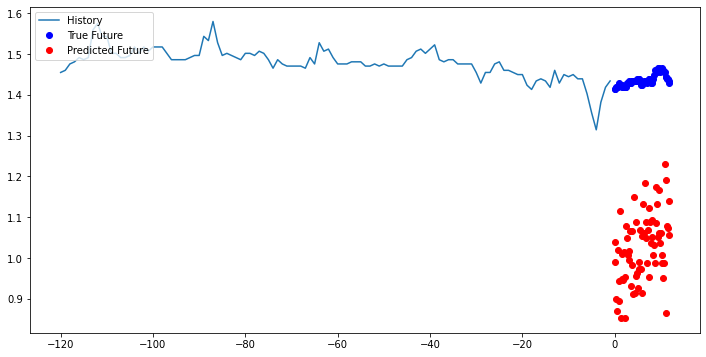

In [ ]:
for x, y in val_data_multi.take(4):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])


In [ ]:
# make predictions
x_train_multi_predict = multi_step_model.predict(x_train_multi)
x_val_multi_predict = multi_step_model.predict(x_val_multi)

print('Train Mean Absolute Error:', mean_absolute_error(y_train_multi[0],x_train_multi_predict[0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train_multi[0], x_train_multi_predict[0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_val_multi[0],x_val_multi_predict[0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_val_multi[0], x_val_multi_predict[0])))



Train Mean Absolute Error: 0.20215384683909898
Train Root Mean Squared Error: 0.2104218552400225
Test Mean Absolute Error: 0.09614207218019047
Test Root Mean Squared Error: 0.10710140420961747
